In [1]:
# SETUP

import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import os

plt.rcParams.update({'font.size': 13}) # Set font size globally

from scipy.fft import fft, fftfreq

# Parameters
n_atoms = 1728

speed_c = 2.997*1e8 # m/s
epsilon_0 = 8.854*1e-12 # F/m = C²/J*m
k_B = 1.3806*1e-23 # J/K
pi = np.pi

known_step = 50001
dt_fs = 0.5 # Time step in fs
# LAMMPS units = real

convert_vacf = (1e-10/1e-15)**2 # convert A to m and fs to s now in (m/s)²

In [2]:
# Helper function to extract all/Na/Cl from filename

def file_get_temp(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else None

In [3]:
# Helper function to extract temperature from filename

def file_sort_by_temp(pattern):
    files = sorted(glob.glob(pattern), key=file_get_temp)
    return {file_get_temp(f): f for f in files}

In [4]:
# Collect files

all_files = sorted(glob.glob("vacf_all*.txt"), key=file_get_temp)
na_files = sorted(glob.glob("vacf_Na*.txt"), key=file_get_temp)
cl_files = sorted(glob.glob("vacf_Cl*.txt"), key=file_get_temp)

In [5]:
# Load all VACF files into temperature-indexed dictionaries

all_vacf_by_temp = file_sort_by_temp("vacf_all*.txt")
na_vacf_by_temp  = file_sort_by_temp("vacf_Na*.txt")
cl_vacf_by_temp  = file_sort_by_temp("vacf_Cl*.txt")

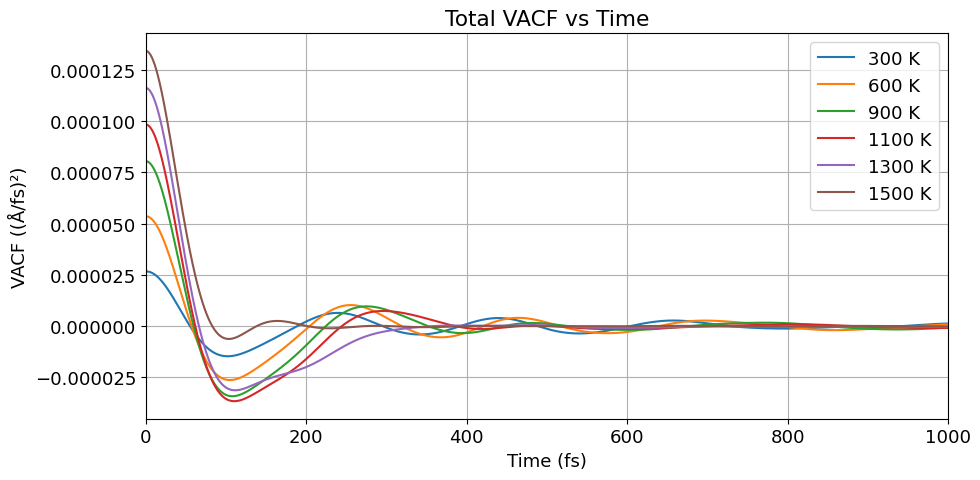

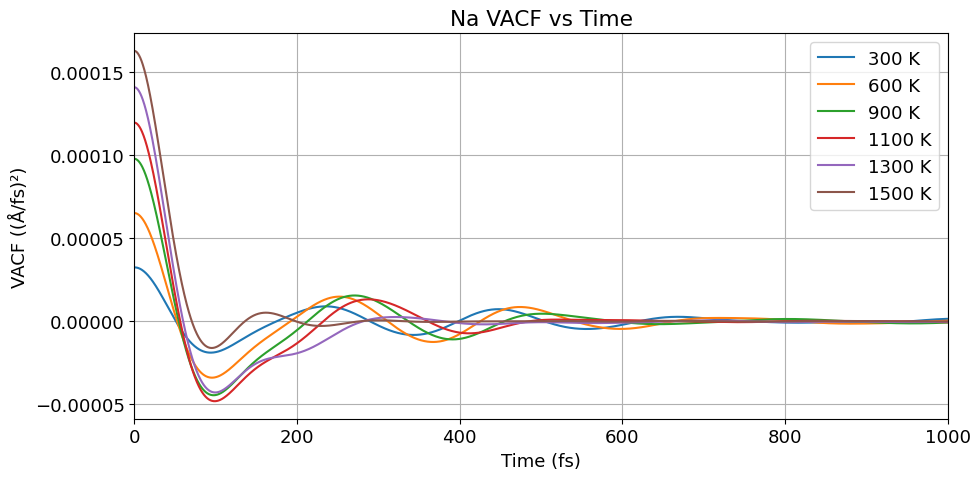

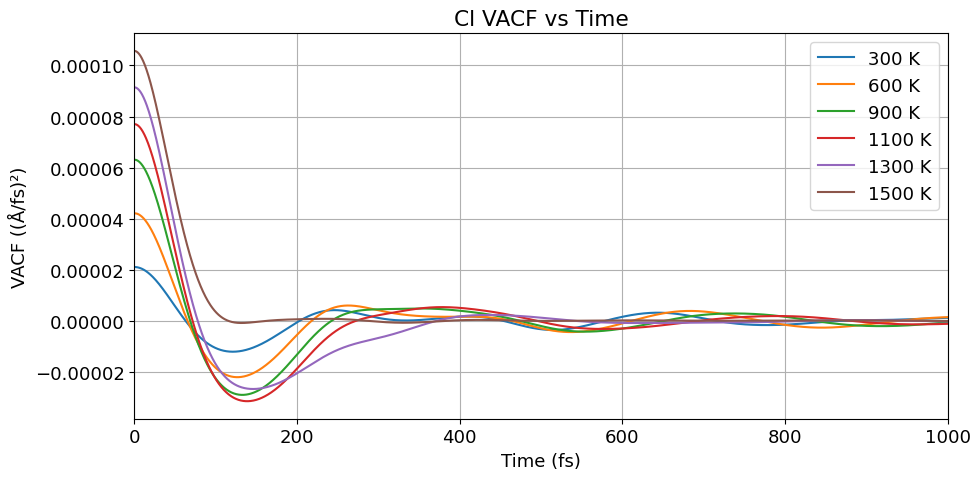

Plots saved: VACF_total.png, VACF_Na.png, VACF_Cl.png


In [6]:
# VACF plotting function

def plot_vacf_set(file_list, label, output_name):
    plt.figure(figsize=(10, 5))

    for filename in file_list:
        temp = file_get_temp(filename)
        vacf = np.loadtxt(filename)
        time = np.arange(len(vacf)) * dt_fs
        plt.plot(time, vacf, label=f"{temp} K")

    plt.title(f"{label} VACF vs Time")
    plt.xlabel("Time (fs)")
    plt.ylabel("VACF ((Å/fs)²)")
    plt.grid(True)
    plt.xlim(0, 1000)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_name}.png", dpi=600)
    plt.show() # plt.close()

# Plot and save each VACF group
plot_vacf_set(all_files, "Total", "cropVACF_total")
plot_vacf_set(na_files, "Na", "cropVACF_Na")
plot_vacf_set(cl_files, "Cl", "cropVACF_Cl")

print("Plots saved: VACF_total.png, VACF_Na.png, VACF_Cl.png")


Diffusion Coefficients (Total) in cm²/s:
  300 K: -4.86357e-07 cm²/s
  600 K: 7.89519e-07 cm²/s
  900 K: 9.10848e-08 cm²/s
  1100 K: 3.30200e-06 cm²/s
  1300 K: 6.68757e-07 cm²/s
  1500 K: 1.85047e-04 cm²/s

Diffusion Coefficients (Na) in cm²/s:
  300 K: -1.03781e-06 cm²/s
  600 K: -9.29888e-07 cm²/s
  900 K: 1.10438e-06 cm²/s
  1100 K: 6.13553e-06 cm²/s
  1300 K: 3.93377e-06 cm²/s
  1500 K: 1.87947e-04 cm²/s

Diffusion Coefficients (Cl) in cm²/s:
  300 K: 6.50995e-08 cm²/s
  600 K: 2.50893e-06 cm²/s
  900 K: -9.22215e-07 cm²/s
  1100 K: 4.68471e-07 cm²/s
  1300 K: -2.59626e-06 cm²/s
  1500 K: 1.82148e-04 cm²/s


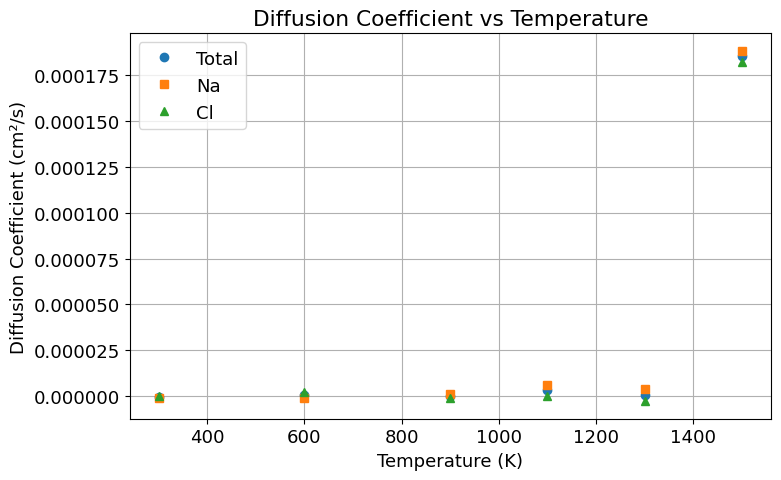

In [18]:
def compute_diffusion_data(file_list, label, dt_fs):
    temps = []
    diffs = []

    print(f"\nDiffusion Coefficients ({label}) in cm²/s:")

    for filename in file_list:
        temp = file_get_temp(filename)
        vacf = np.loadtxt(filename)
        time = np.arange(len(vacf)) * dt_fs  # fs

        # Integrate VACF
        integral = np.trapz(vacf, x=time)  # Å²/fs
        diffusion_ang2_per_fs = integral / 3
        diffusion_cm2_per_s = diffusion_ang2_per_fs * (1e-8**2/1e-15) # convert A to cm and fs to s now in (cm^2/s) 

        temps.append(temp)
        diffs.append(diffusion_cm2_per_s)

        print(f"  {temp} K: {diffusion_cm2_per_s:.5e} cm²/s")

    return np.array(temps), np.array(diffs)

# Compute and print data
temps_total, diffs_total = compute_diffusion_data(all_files, "Total", dt_fs)
temps_na,    diffs_na    = compute_diffusion_data(na_files,  "Na",    dt_fs)
temps_cl,    diffs_cl    = compute_diffusion_data(cl_files,  "Cl",    dt_fs)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(temps_total, diffs_total, 'o', label='Total')
plt.plot(temps_na,    diffs_na,    's', label='Na')
plt.plot(temps_cl,    diffs_cl,    '^', label='Cl')

plt.xlabel("Temperature (K)")
plt.ylabel("Diffusion Coefficient (cm²/s)")
plt.title("Diffusion Coefficient vs Temperature")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("diffusion_vs_temperature.png", dpi=600)
plt.show()

# There may be an issue here with the noise flow. The diffusion coefficient should not be negative

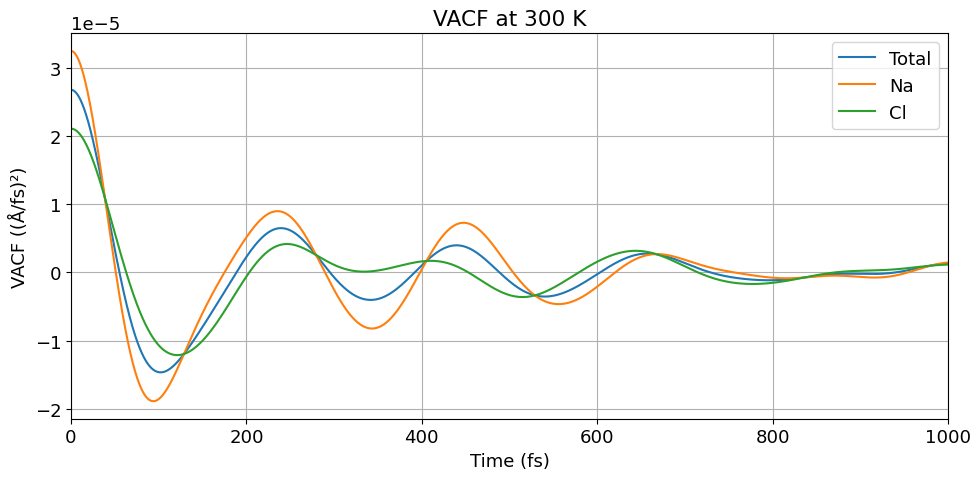

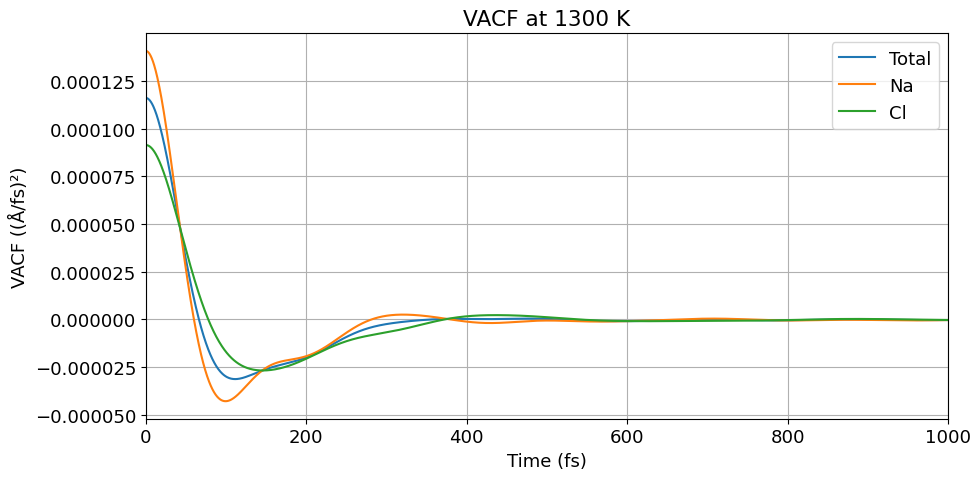

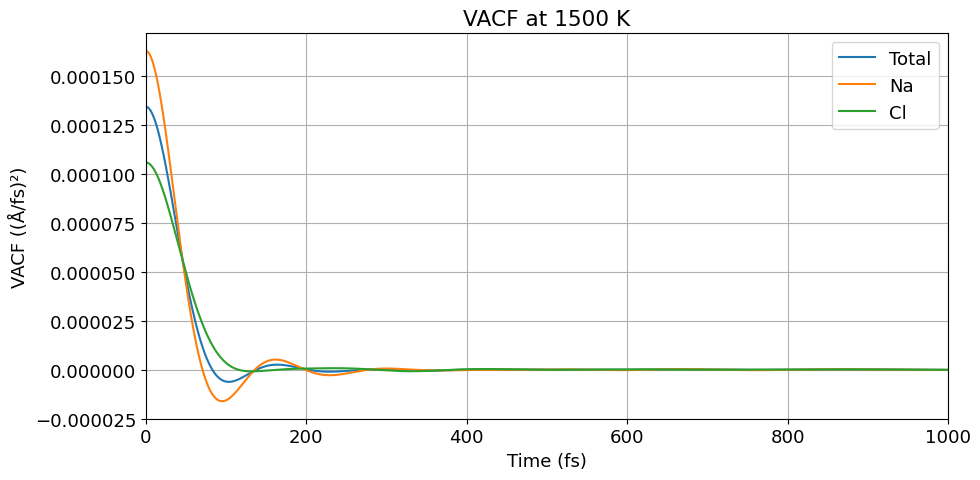

In [8]:
def plot_vacf_by_temperature(temps_to_plot):
    for temp in temps_to_plot:
        if temp not in all_vacf_by_temp or temp not in na_vacf_by_temp or temp not in cl_vacf_by_temp: 
            print(f"Skipping {temp} K (data missing)")
            continue

        # Load each VACF curve
        vacf_all = np.loadtxt(all_vacf_by_temp[temp])
        vacf_na  = np.loadtxt(na_vacf_by_temp[temp])
        vacf_cl  = np.loadtxt(cl_vacf_by_temp[temp])

        time = np.arange(len(vacf_na)) * dt_fs

        plt.figure(figsize=(10, 5))
        plt.plot(time, vacf_all, label='Total')
        plt.plot(time, vacf_na, label='Na')
        plt.plot(time, vacf_cl, label='Cl')

        plt.title(f"VACF at {temp} K")
        plt.xlabel("Time (fs)")
        plt.ylabel("VACF ((Å/fs)²)")
        plt.xlim(0, 1000)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{temp}cropVACF_all.png", dpi=600)
        plt.show()

plot_vacf_by_temperature([300, 1300, 1500])

In [9]:
def compute_fft(acf, dt_fs, output_freq_unit='THz'):
    """
    Compute the Fourier transform of an autocorrelation function.

    Parameters:
    - acf : 1D numpy array of ACF values
    - dt_fs : timestep duration in femtoseconds
    - output_freq_unit : 'Hz', 'THz', or 'rad/s'

    Returns:
    - freqs : frequencies (in desired unit)
    - spectrum : real part of the FFT of the ACF
    """
    
    # Convert timestep from fs to seconds
    dt = dt_fs * 1e-15  # [s]

    # Number of time points
    N = len(acf)

    # FFT
    spectrum = fft(acf) 
    spectrum_real = np.real(spectrum)
    spectrum_imag = np.imag(spectrum)
    spectrum_power = np.abs(spectrum)**2

    # Frequencies (in Hz by default)
    freqs = fftfreq(N, d=dt)

    # Convert frequency units
    if output_freq_unit == 'THz':
        freqs /= 1e12
    elif output_freq_unit == 'rad/s':
        freqs *= 2 * np.pi
    # Else keep in Hz

    # Extract only positive frequencies... necessary to multiply by the sampling period because I want the continuous fourier transform
    # This function computes the one-dimensional n-point discrete Fourier Transform (DFT) with the efficient Fast Fourier Transform (FFT) algorithm
    mask = freqs > 0
    freqs = freqs[mask]
    spectrum = spectrum[mask] * dt
    spectrum_real = spectrum_real[mask] * dt
    spectrum_imag = spectrum_imag[mask] * dt
    spectrum_power = spectrum_power[mask] * dt

    return freqs, spectrum_real, spectrum_imag, spectrum_power

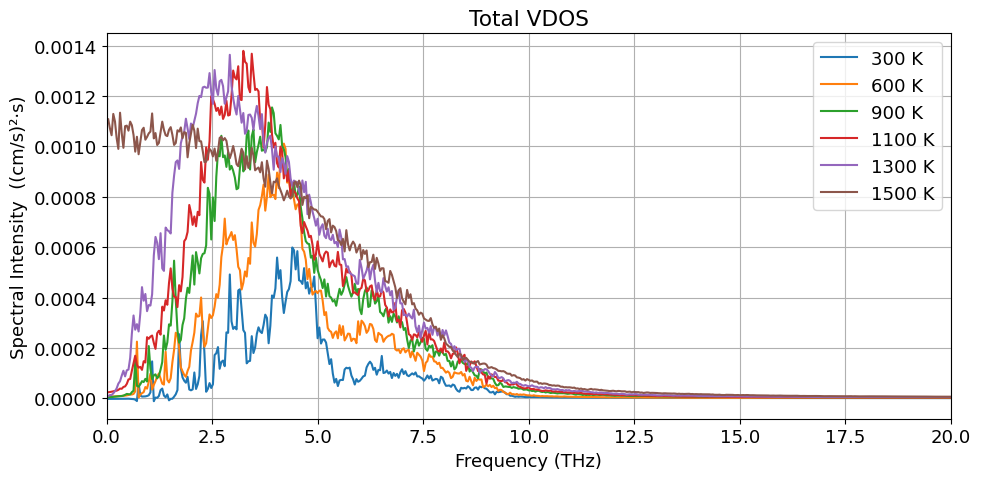

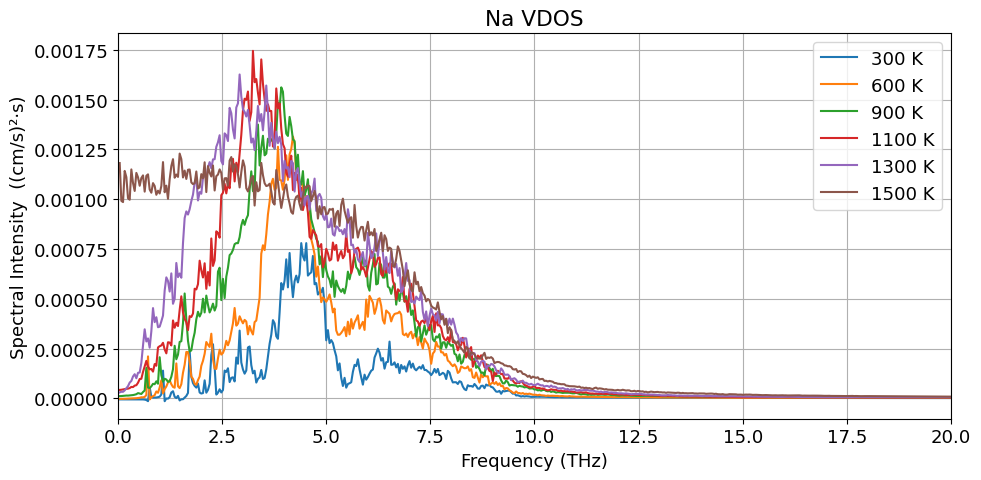

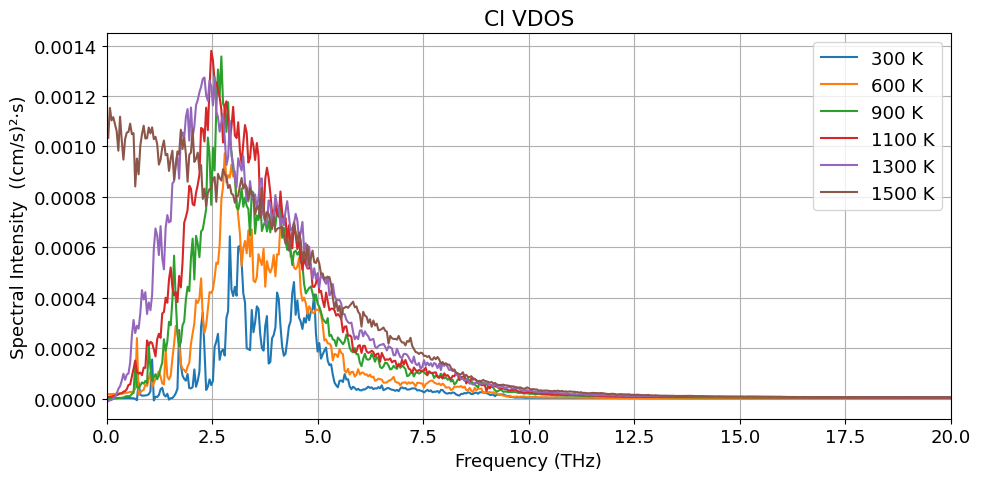

VDOS plots saved: VDOS_total.png, VDOS_Na.png, VDOS_Cl.png


In [10]:
# VDOS plotting function

def plot_fourier(file_list, label, output_name):
    plt.figure(figsize=(10, 5))
    for file in file_list:
        temp = file_get_temp(file)
        acf = np.loadtxt(file)
        freqs, spectrum, _, _ = compute_fft(acf*convert_vacf, dt_fs, output_freq_unit='THz')
        plt.plot(freqs, 10000*2*spectrum, label=f"{temp} K")
    plt.title(f"{label} VDOS")
    plt.xlabel("Frequency (THz)")
    plt.ylabel("Spectral Intensity  ((cm/s)²⋅s)")
    plt.grid(True)
    plt.xlim(0, 20)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_name}.png", dpi=600)
    plt.show() # plt.close()

# Generate plots
plot_fourier(all_files, "Total", "VDOS_total")
plot_fourier(na_files, "Na", "VDOS_Na")
plot_fourier(cl_files, "Cl", "VDOS_Cl")

print("VDOS plots saved: VDOS_total.png, VDOS_Na.png, VDOS_Cl.png")

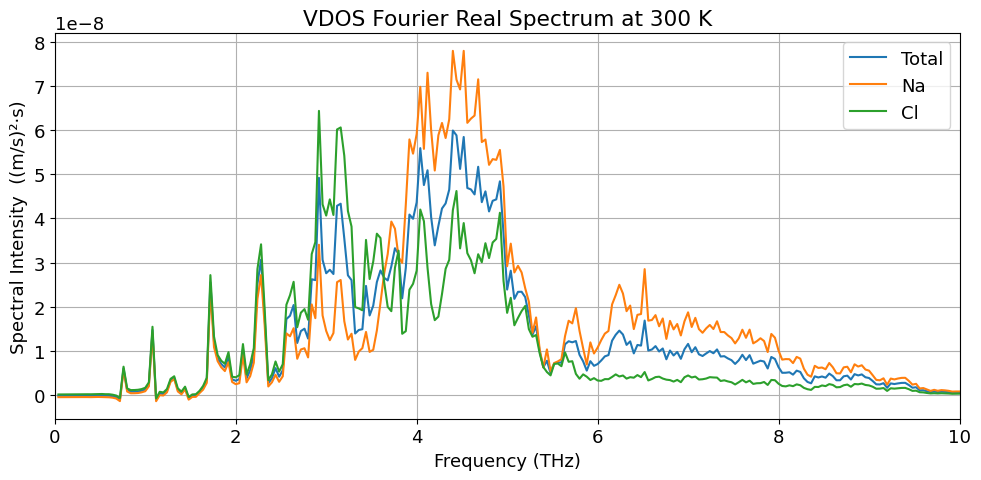

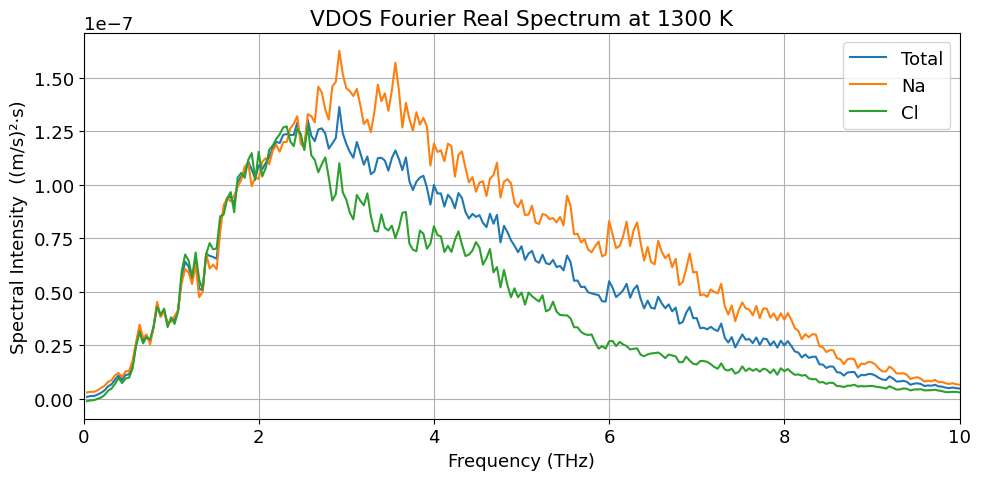

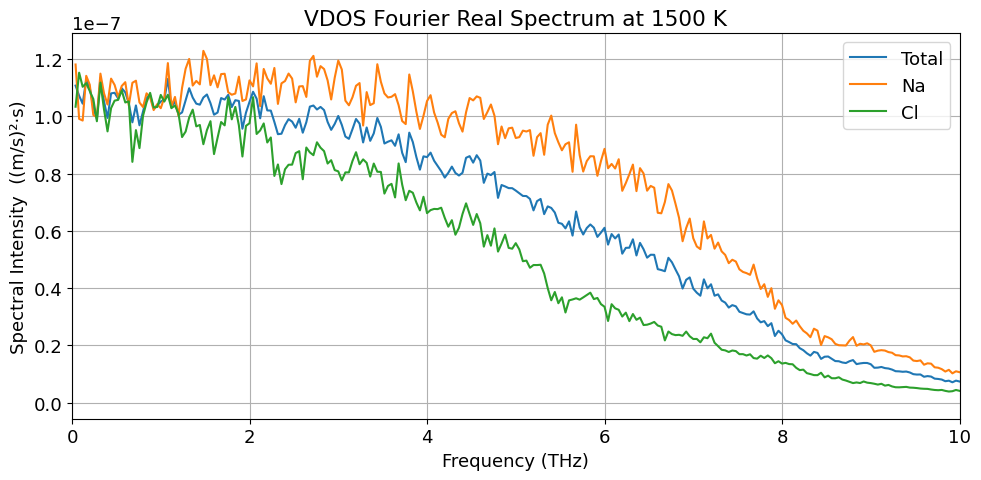

In [11]:
def plot_fourier_by_temperature(temps_to_plot):
    for temp in temps_to_plot:
        if temp not in all_vacf_by_temp or temp not in na_vacf_by_temp or temp not in cl_vacf_by_temp:
            print(f"Skipping {temp} K (data missing)")
            continue

        # Load ACFs
        acf_all = np.loadtxt(all_vacf_by_temp[temp])
        acf_na  = np.loadtxt(na_vacf_by_temp[temp])
        acf_cl  = np.loadtxt(cl_vacf_by_temp[temp])

        # Compute FFT
        freqs_all, spectrum_allr, _, _ = compute_fft(acf_all*convert_vacf, dt_fs, output_freq_unit='THz')
        freqs_na, spectrum_nar, _, _  = compute_fft(acf_na*convert_vacf, dt_fs, output_freq_unit='THz')
        freqs_cl, spectrum_clr, _, _  = compute_fft(acf_cl*convert_vacf, dt_fs, output_freq_unit='THz')

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(freqs_all, 2*spectrum_allr, label='Total')
        plt.plot(freqs_na,  2*spectrum_nar,  label='Na')
        plt.plot(freqs_cl,  2*spectrum_clr,  label='Cl')

        plt.title(f"VDOS Fourier Real Spectrum at {temp} K")
        plt.xlabel("Frequency (THz)")
        plt.ylabel("Spectral Intensity  ((m/s)²⋅s)")
        plt.grid(True)
        plt.xlim(0, 10)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_fourier_by_temperature([300, 1300, 1500])

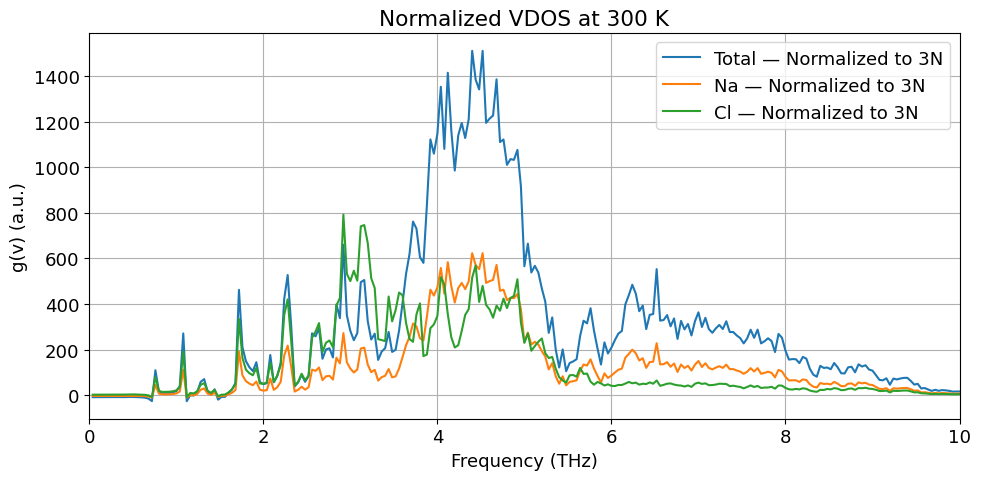

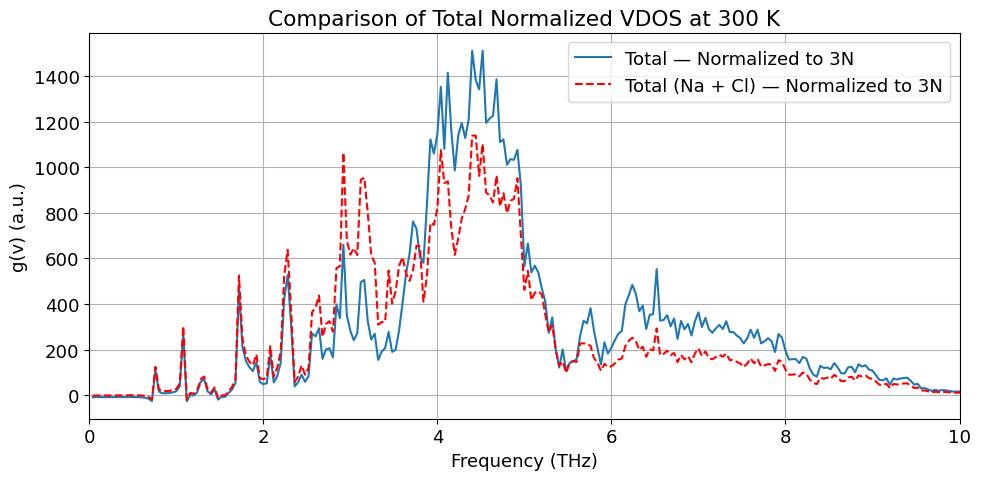

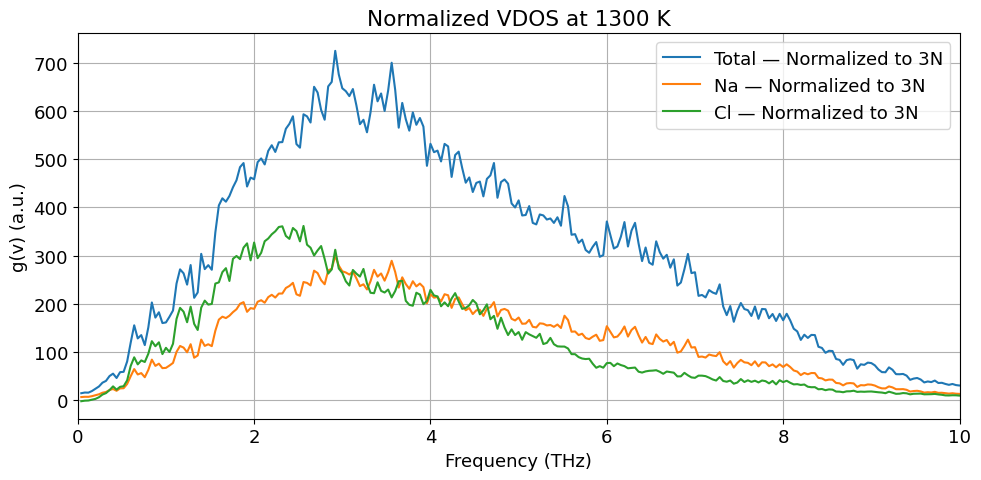

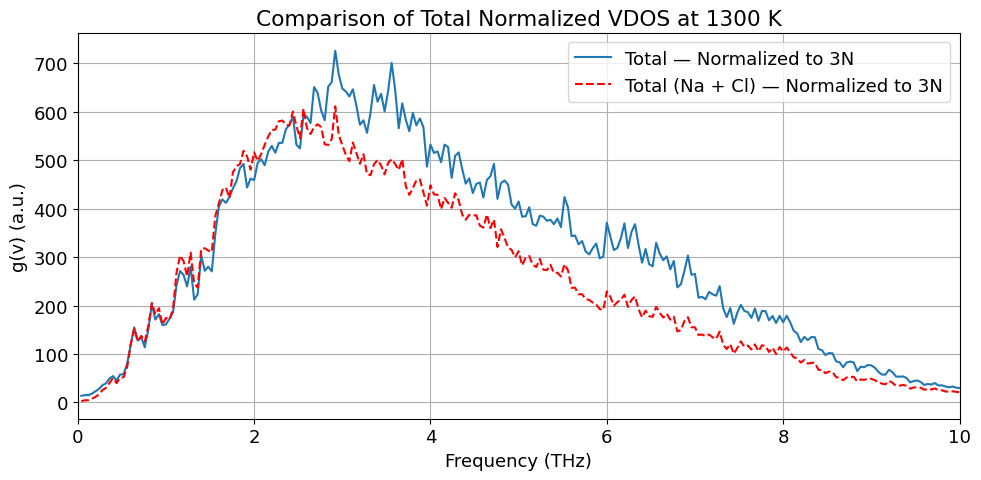

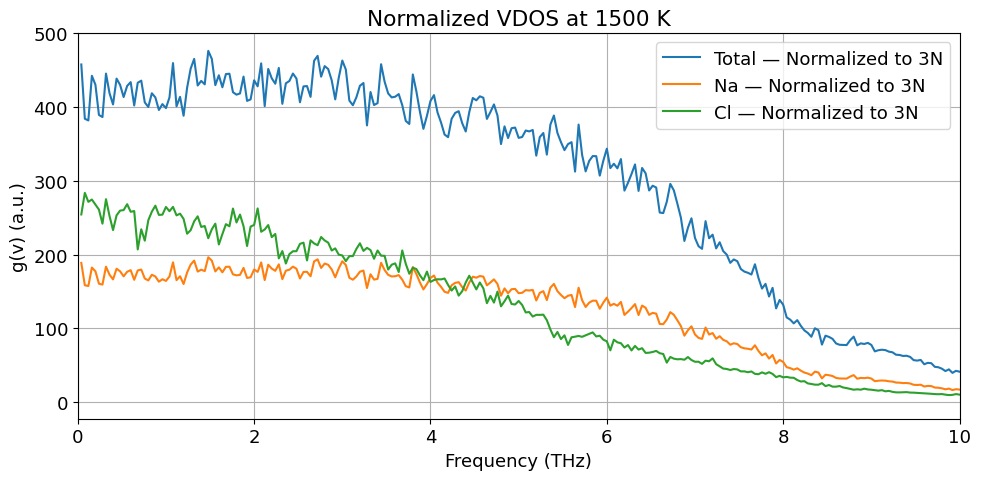

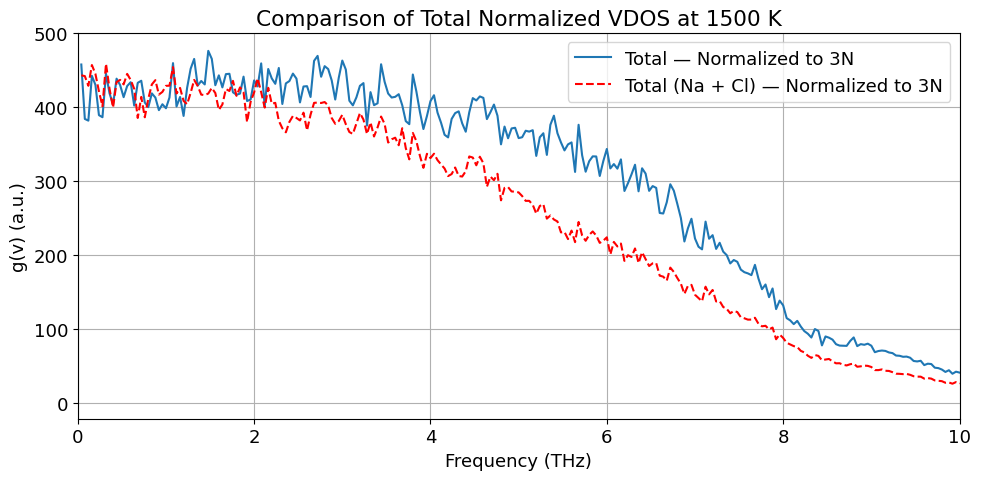

In [12]:
def plot_normalized_by_temperature(temps_to_plot):
    for temp in temps_to_plot:
        if temp not in all_vacf_by_temp or temp not in na_vacf_by_temp or temp not in cl_vacf_by_temp:
            print(f"Skipping {temp} K (data missing)")
            continue

        # Load ACFs
        acf_all = np.loadtxt(all_vacf_by_temp[temp])
        acf_na  = np.loadtxt(na_vacf_by_temp[temp])
        acf_cl  = np.loadtxt(cl_vacf_by_temp[temp])

        # Compute FFT
        freqs_all, spectrum_allr, _, _ = compute_fft(acf_all*convert_vacf, dt_fs, output_freq_unit='THz')
        freqs_na, spectrum_nar, _, _  = compute_fft(acf_na*convert_vacf, dt_fs, output_freq_unit='THz')
        freqs_cl, spectrum_clr, _, _  = compute_fft(acf_cl*convert_vacf, dt_fs, output_freq_unit='THz')

        # Normalize to 3N
        cl_atoms = n_atoms/2
        na_atoms = n_atoms/2

        spectrum_allr = (3 * n_atoms) * 2*spectrum_nar / np.trapz(2*spectrum_allr, freqs_all)
        spectrum_nar = (3 * cl_atoms) * 2*spectrum_nar / np.trapz(2*spectrum_nar, freqs_na)
        spectrum_clr = (3 * na_atoms) * 2*spectrum_clr / np.trapz(2*spectrum_clr, freqs_cl)
        
        # Combine to see if there is significant contribution from Na-Cl VACF interaction
        spectrum_na_clr = spectrum_nar + spectrum_clr

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(freqs_all, spectrum_allr, label='Total — Normalized to 3N')
        plt.plot(freqs_na, spectrum_nar, label='Na — Normalized to 3N')
        plt.plot(freqs_cl, spectrum_clr, label='Cl — Normalized to 3N')

        plt.title(f"Normalized VDOS at {temp} K")
        plt.xlabel("Frequency (THz)")
        plt.ylabel("g(v) (a.u.)")
        plt.grid(True)
        plt.xlim(0, 10)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{temp}normalized_VDOS_all.png", dpi=600)
        plt.show()

        # Comparison
        plt.figure(figsize=(10, 5))
        plt.plot(freqs_all, spectrum_allr, label='Total — Normalized to 3N')
        plt.plot(freqs_all, spectrum_na_clr, color='red', linestyle='--',  label='Total (Na + Cl) — Normalized to 3N')

        plt.title(f"Comparison of Total Normalized VDOS at {temp} K")
        plt.xlabel("Frequency (THz)")
        plt.ylabel("g(v) (a.u.)")
        plt.grid(True)
        plt.xlim(0, 10)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{temp}compare_total.png", dpi=600)
        plt.show()
  
plot_normalized_by_temperature([300, 1300, 1500])